### Import Package

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
import sklearn
import cv2
import os

from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

### Masking
- Use rectangular masks to separately block the model and the outer cubic frame. This facilitates the subsequent extraction of red points on the cubic frame and laser scan data points.

In [2]:
# Set the directory path for the original images & processed images
origin_image_path = "ShadowStrip"
processed_path = "AfterProcess_Box"

# Loop through each file in the original image directory
for img in os.listdir(origin_image_path):
    # Check if the file is an image with a valid extension
    if img.endswith(('.png', '.jpg', '.jpeg')):
        # Read the image using the cv2 library
        image = cv2.imread(os.path.join(origin_image_path, img))
        # Draw a black rectangle on the image from coordinates (350, 250) to (600, 680)
        cv2.rectangle(image, (350, 250), (600, 680), (0, 0, 0), -1)
        # Disable axis labels in the plot
        plt.axis('off')
        # Define the path for saving the processed image
        processed_img_path = os.path.join(processed_path, img)
        # Save the image with colors converted from BGR to RGB format using matplotlib
        plt.imsave(processed_img_path, cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.close()

In [3]:
# Set the directory path for the original images & processed images
origin_image_path = "ShadowStrip"
processed_path = "AfterProcess_Model"

# Loop through each file in the directory specified by origin_image_path
for img in os.listdir(origin_image_path):
    # Check if the file is an image file with one of the specified extensions
    if img.endswith(('.png', '.jpg', '.jpeg')):
        # Read the image from the file using OpenCV
        image = cv2.imread(os.path.join(origin_image_path, img))
        # Create a mask of zeros with the same size and type as the image
        mask = np.zeros_like(image, dtype=np.uint8)
        # Draw a black rectangle over the entire mask
        cv2.rectangle(mask, (0, 0), (image.shape[1], image.shape[0]), (0, 0, 0), -1)  
        # Draw a white rectangle on the mask at specified coordinates
        cv2.rectangle(mask, (350, 250), (600, 680), (255, 255, 255), -1)
        # Apply the mask to the image using bitwise AND operation, which keeps only the area inside the white rectangle
        result = cv2.bitwise_and(image, mask)
        # Turn off the axis labels in the plot
        plt.axis('off')          
        # Set the path to save the processed image
        processed_img_path = os.path.join(processed_path, img)
        # Save the processed image after converting the color from BGR to RGB
        plt.imsave(processed_img_path, cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.close()

### Red Channel Filtering
- Read the images processed by masking, convert them from BGR channel to HSV channel, and set thresholds to filter out red pixels in the images.

In [4]:
# Suppress unnecessary warnings
warnings.filterwarnings("ignore")

# Set the directory for processed images
processed_path = "./AfterProcess_Box"

# Define HSV color ranges for light and dark red
light_red_min = np.array([0, 23, 0])
light_red_max = np.array([15, 255, 255])
dark_red_min = np.array([155, 23, 0])
dark_red_max = np.array([180, 255, 180])

# Function to process an image and extract red points
def process_image(image_path):
    image = cv2.imread(image_path)
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask_light_red = cv2.inRange(image_hsv, light_red_min, light_red_max)
    mask_dark_red = cv2.inRange(image_hsv, dark_red_min, dark_red_max)
    mask_red = cv2.bitwise_or(mask_light_red, mask_dark_red)
    kernel = np.ones((3,3), np.uint8)
    mask_red = cv2.morphologyEx(mask_red, cv2.MORPH_OPEN, kernel)
    red_pixels = np.where(mask_red != 0)
    points = np.column_stack((red_pixels[1], red_pixels[0]))
    return points

### Kmeans Clustering
- Utilize the sklearn kmeans algorithm to approximate four points for the filtered cubic points.

In [5]:
# Collect center points of red clusters from each image
centers_list = []
for img in os.listdir(processed_path):
    if img.endswith(('.png', '.jpg', '.jpeg')):
        points = process_image(os.path.join(processed_path, img))
        if len(points) > 0:
            kmeans = KMeans(n_clusters=4, random_state=42).fit(points)
            centers = np.round(kmeans.cluster_centers_).astype(int)
            centers_list.append(centers)

# Sort the points in each cluster in a clockwise direction
def sort_points_clockwise(points):
    centroid = np.mean(points, axis=0)
    angles = np.arctan2(points[:,1] - centroid[1], points[:,0] - centroid[0])
    angles = np.where(angles < 0, angles + 2*np.pi, angles)
    sorted_indices = np.argsort(angles)
    sorted_points = points[sorted_indices]
    return sorted_points

# Sort all collected center points
centers_list_sorted = [sort_points_clockwise(centers) for centers in centers_list]

### Homography Calculation
- Transform all four points of the images to the coordinates [98.5, 98.5], [-98.5, 98.5], [-98.5, -98.5], [98.5, -98.5] through homography.

In [6]:
# Initialize a list to store homography matrices
H_list = []

# Define the destination points for the homography transformation
dst_points = np.array([[98.5, 98.5], [-98.5, 98.5], [-98.5, -98.5], [98.5, -98.5]], dtype=np.float32)

# Calculate the homography matrix for each set of sorted center points
for centers in centers_list_sorted:
    # Ensure each set of centers contains exactly four points
    if len(centers) == 4:
        # Compute the homography matrix using OpenCV, mapping centers to destination points
        H, _ = cv2.findHomography(centers, dst_points)
        # Append the calculated homography matrix to the list
        H_list.append(H)

### Z Axis Calculation
- Select the pixel coordinates of the left and right boundaries from the images, and interpolate along the x-axis. In this project, the interpolated values of all four boundary points are averaged to obtain the Z-axis coordinates.

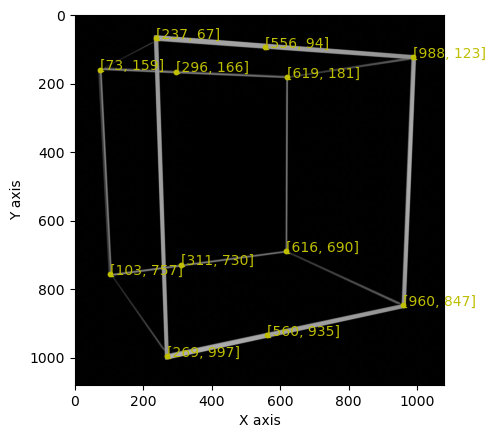

In [7]:
# Define start, end, and mid points for annotation on an image
start_points = [[237, 67], [73, 159], [103, 757], [269, 997]]
end_points = [[988, 123], [619, 181], [616, 690], [960, 847]]
mid_points = [[560, 935], [311, 730], [296, 166], [556, 94]]

# Combine all points into a single list for processing
points = start_points + end_points + mid_points

# Load the specified image
image = cv2.imread("AfterProcess_Box/0000.jpg")

# Extract x and y coordinates from the combined list of points
x = [point[0] for point in points]
y = [point[1] for point in points]

# Plot the points on the image using matplotlib
plt.scatter(x, y, c='y', s=10, marker='o')  # Yellow color, size 10, circle marker

# Annotate each point with its coordinates on the image
for i, txt in enumerate(points):
    plt.annotate(txt, (x[i], y[i]), color='y')  # Annotation text in yellow

# Display the image with points annotated
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.xlabel('X axis')  # Label for the X axis
plt.ylabel('Y axis')  # Label for the Y axis
plt.show()  # Show the plot

In [8]:
# Initialize a list to store z-axis values
z_list = []

# Define a function to interpolate x-coordinates to millimeters
def interpolate(num, mode):
    # Set the boundaries in millimeters
    start_mm = -100
    end_mm = 100
    # Define conversion points based on specified mode
    if mode == "LowerLeft":
        start_point = 103
        end_point = 616
    elif mode == "LowerRight":
        start_point = 269
        end_point = 960
    elif mode == "UpperLeft":
        start_point = 73
        end_point = 619
    elif mode == "UpperRight":
        start_point = 237
        end_point = 988
    else:
        return "Error"
    
    # Calculate the interpolated result
    result = (end_mm - start_mm) / (end_point - start_point) * (num - start_point) + start_mm
    return result

# Calculate average interpolated z-values for each set of center points
for i in range(len(centers_list_sorted)):
    a = interpolate(centers_list_sorted[i][0][0], "LowerRight")
    b = interpolate(centers_list_sorted[i][1][0], "LowerLeft")
    c = interpolate(centers_list_sorted[i][2][0], "UpperLeft")
    d = interpolate(centers_list_sorted[i][3][0], "UpperRight")
    final = (a + b + c + d) / 4
    z_list.append(final)

### Apply Homography
- Apply the calculated H matrices to the pixels of the red scan line model extracted from the images.


In [9]:
# Define path to the model images
model_path = "./AfterProcess_Model"

# Ensure the number of homography matrices matches the number of relevant model images
assert len(H_list) == len([img for img in os.listdir(model_path) if img.endswith(('.png', '.jpg', '.jpeg'))])

# Initialize a list to store 3D model points
model_point_list = []

# Iterate through sorted list of images in the model directory
for img_index, img in enumerate(sorted(os.listdir(model_path))):
    # Process only image files
    if img.endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(model_path, img)
        points = process_image(image_path)
        # Check if points are detected and the corresponding homography matrix is available
        if len(points) > 0 and img_index < len(H_list):
            H = H_list[img_index]  # Retrieve the homography matrix for the current image
            points_array = np.array([points], dtype=np.float32)  # Prepare points for transformation
            points_transformed = cv2.perspectiveTransform(points_array, H)[0]  # Apply homography
            
            # Initialize an array to hold the 3D coordinates of the points
            points_3d = np.zeros((len(points_transformed), 3), dtype=np.float32)
            points_3d[:, :2] = points_transformed  # Fill in the x, y coordinates
            points_3d[:, 2] = z_list[img_index]  # Set the z coordinate to the interpolated value
            
            # Append the three dimension coordinates to the list
            model_point_list.append(points_3d)

### Rough evaluation
- Visualize the 3D model points in program

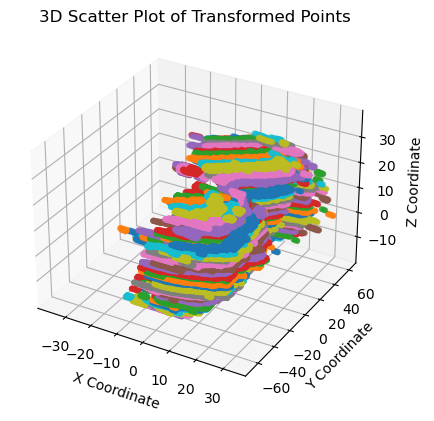

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for points_3d in model_point_list:
    ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], s=10)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
ax.set_title('3D Scatter Plot of Transformed Points')
plt.show()

### Model Evaluation Output
- Export xyz files and import them into meshlab for evaluating the reconstruction accuracy.

In [11]:
'''Save 3D points to .xyz file'''
with open("R12522636.xyz", "w") as f:
    for i, points_3d in enumerate(model_point_list):
        for point in points_3d:
            f.write(" ".join(str(coord) for coord in (-point[2]+6, -point[0], -point[1])))
            f.write("\n")